In [1]:
import os
import random
import shutil
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0, ResNet50
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import math

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
import numpy as np
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report


In [2]:
# Define dataset path
dataset_path = "/Users/rajendarbore/Downloads/Yamini Project/PokemonData"

In [ ]:
# Define dataset path
dataset_path = "/Users/rajendarbore/Downloads/Yamini Project/PokemonData"

# Get list of subfolders
subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Prepare files and their corresponding labels
files = []
labels = []
for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            files.append(os.path.join(folder_path, file))
            labels.append(folder)

# Perform a train-test split (70% train + 30% temp)
train_files, testval_files, train_labels, testval_labels = train_test_split(files, labels, test_size=0.3, stratify=labels, random_state=42)

# Perform another split on the 30% to get 15% for validation and 15% for test
val_files, test_files, val_labels, test_labels = train_test_split(testval_files, testval_labels, test_size=0.5, stratify=testval_labels, random_state=42)

# Define the target directory for the splits
split_base_path = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits"

# Create directories for train, validation, and test splits
os.makedirs(os.path.join(split_base_path, "train"), exist_ok=True)
os.makedirs(os.path.join(split_base_path, "val"), exist_ok=True)
os.makedirs(os.path.join(split_base_path, "test"), exist_ok=True)

# Move the train files
for file in train_files:
    class_name = file.split(os.path.sep)[-2]
    destination_folder = os.path.join(split_base_path, "train", class_name)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(file, destination_folder)

# Move the validation files
for file in val_files:
    class_name = file.split(os.path.sep)[-2]
    destination_folder = os.path.join(split_base_path, "val", class_name)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(file, destination_folder)

# Move the test files
for file in test_files:
    class_name = file.split(os.path.sep)[-2]
    destination_folder = os.path.join(split_base_path, "test", class_name)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(file, destination_folder)

print("Train, Validation, and Test splits completed successfully.")


In [3]:
# Define the path to  dataset splits
train_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/train"
val_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/val"
test_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/test"

In [3]:
# Define the path to dataset splits
train_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/train"
val_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/val"
test_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/test"

# Function to count images in a folder
def count_images_in_folder(folder_path):
    total_images = 0
    # Loop through all subfolders (representing Pokémon classes)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count the images (files with .jpg or .png extension)
            image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg') or f.endswith('.png')]
            total_images += len(image_files)
    return total_images

# Count the images in train, validation, and test directories
train_images_count = count_images_in_folder(train_dir)
val_images_count = count_images_in_folder(val_dir)
test_images_count = count_images_in_folder(test_dir)

# Print the counts
print(f"Number of images in the Train set: {train_images_count}")
print(f"Number of images in the Validation set: {val_images_count}")
print(f"Number of images in the Test set: {test_images_count}")


Number of images in the Train set: 1402
Number of images in the Validation set: 301
Number of images in the Test set: 301


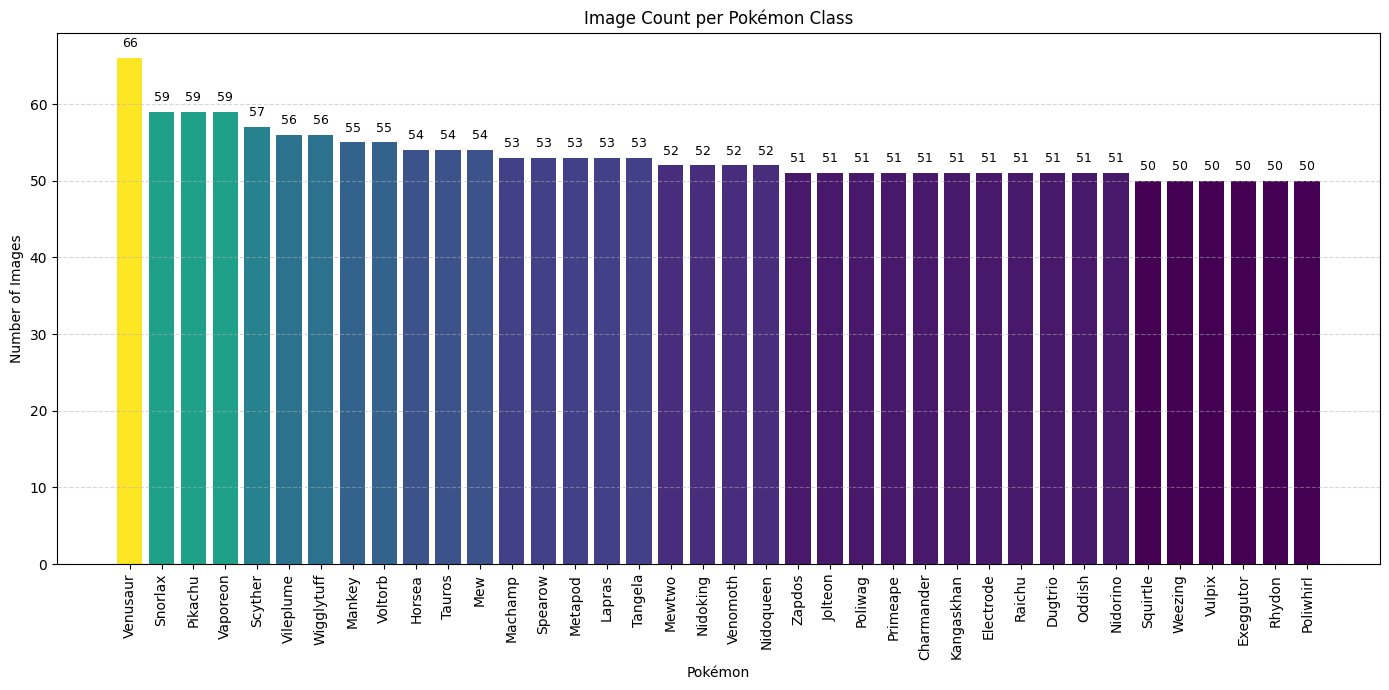

In [6]:
# Get image counts
class_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) 
                for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))}

# Sort classes by count
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
classes = list(sorted_counts.keys())
counts = list(sorted_counts.values())

# Create color gradient
norm = plt.Normalize(min(counts), max(counts))
colors = cm.viridis(norm(counts))

# Plot
plt.figure(figsize=(14, 7))
bars = plt.bar(classes, counts, color=colors)

# Add count labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, str(yval), 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=90)
plt.title('Image Count per Pokémon Class')
plt.xlabel('Pokémon')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


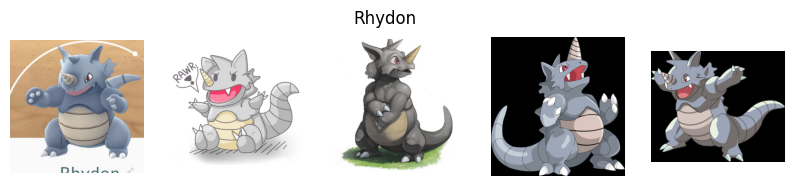

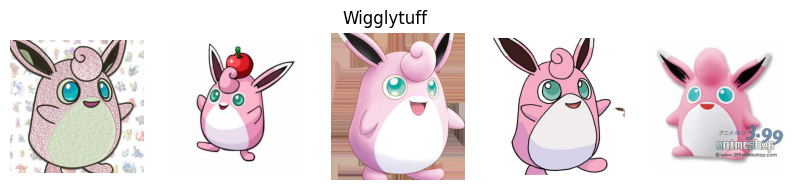

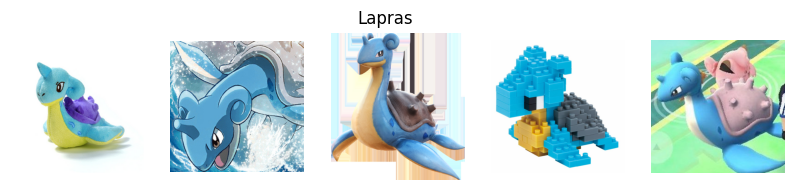

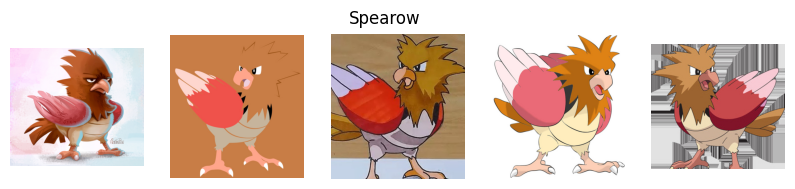

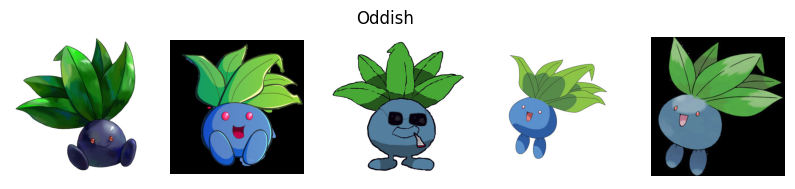

In [7]:

n_classes_to_display = 5
n_images_per_class = 5

sample_classes = random.sample(list(class_counts.keys()), n_classes_to_display)

for cls in sample_classes:
    folder = os.path.join(dataset_path, cls)
    images = random.sample(os.listdir(folder), n_images_per_class)
    fig, axs = plt.subplots(1, n_images_per_class, figsize=(10, 2))
    fig.suptitle(cls)
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()


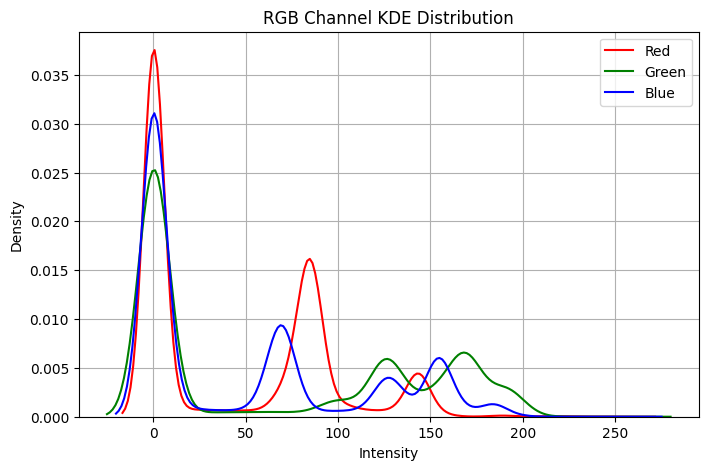

In [8]:

# Convert image to numpy array
img_array = np.array(img)

# Flatten the RGB channels
reds = img_array[:, :, 0].flatten()
greens = img_array[:, :, 1].flatten()
blues = img_array[:, :, 2].flatten()

# Plot KDE
plt.figure(figsize=(8, 5))
sns.kdeplot(reds, color='red', label='Red')
sns.kdeplot(greens, color='green', label='Green')
sns.kdeplot(blues, color='blue', label='Blue')
plt.legend()
plt.title("RGB Channel KDE Distribution")
plt.xlabel("Intensity")
plt.ylabel("Density")
plt.grid(True)
plt.show()


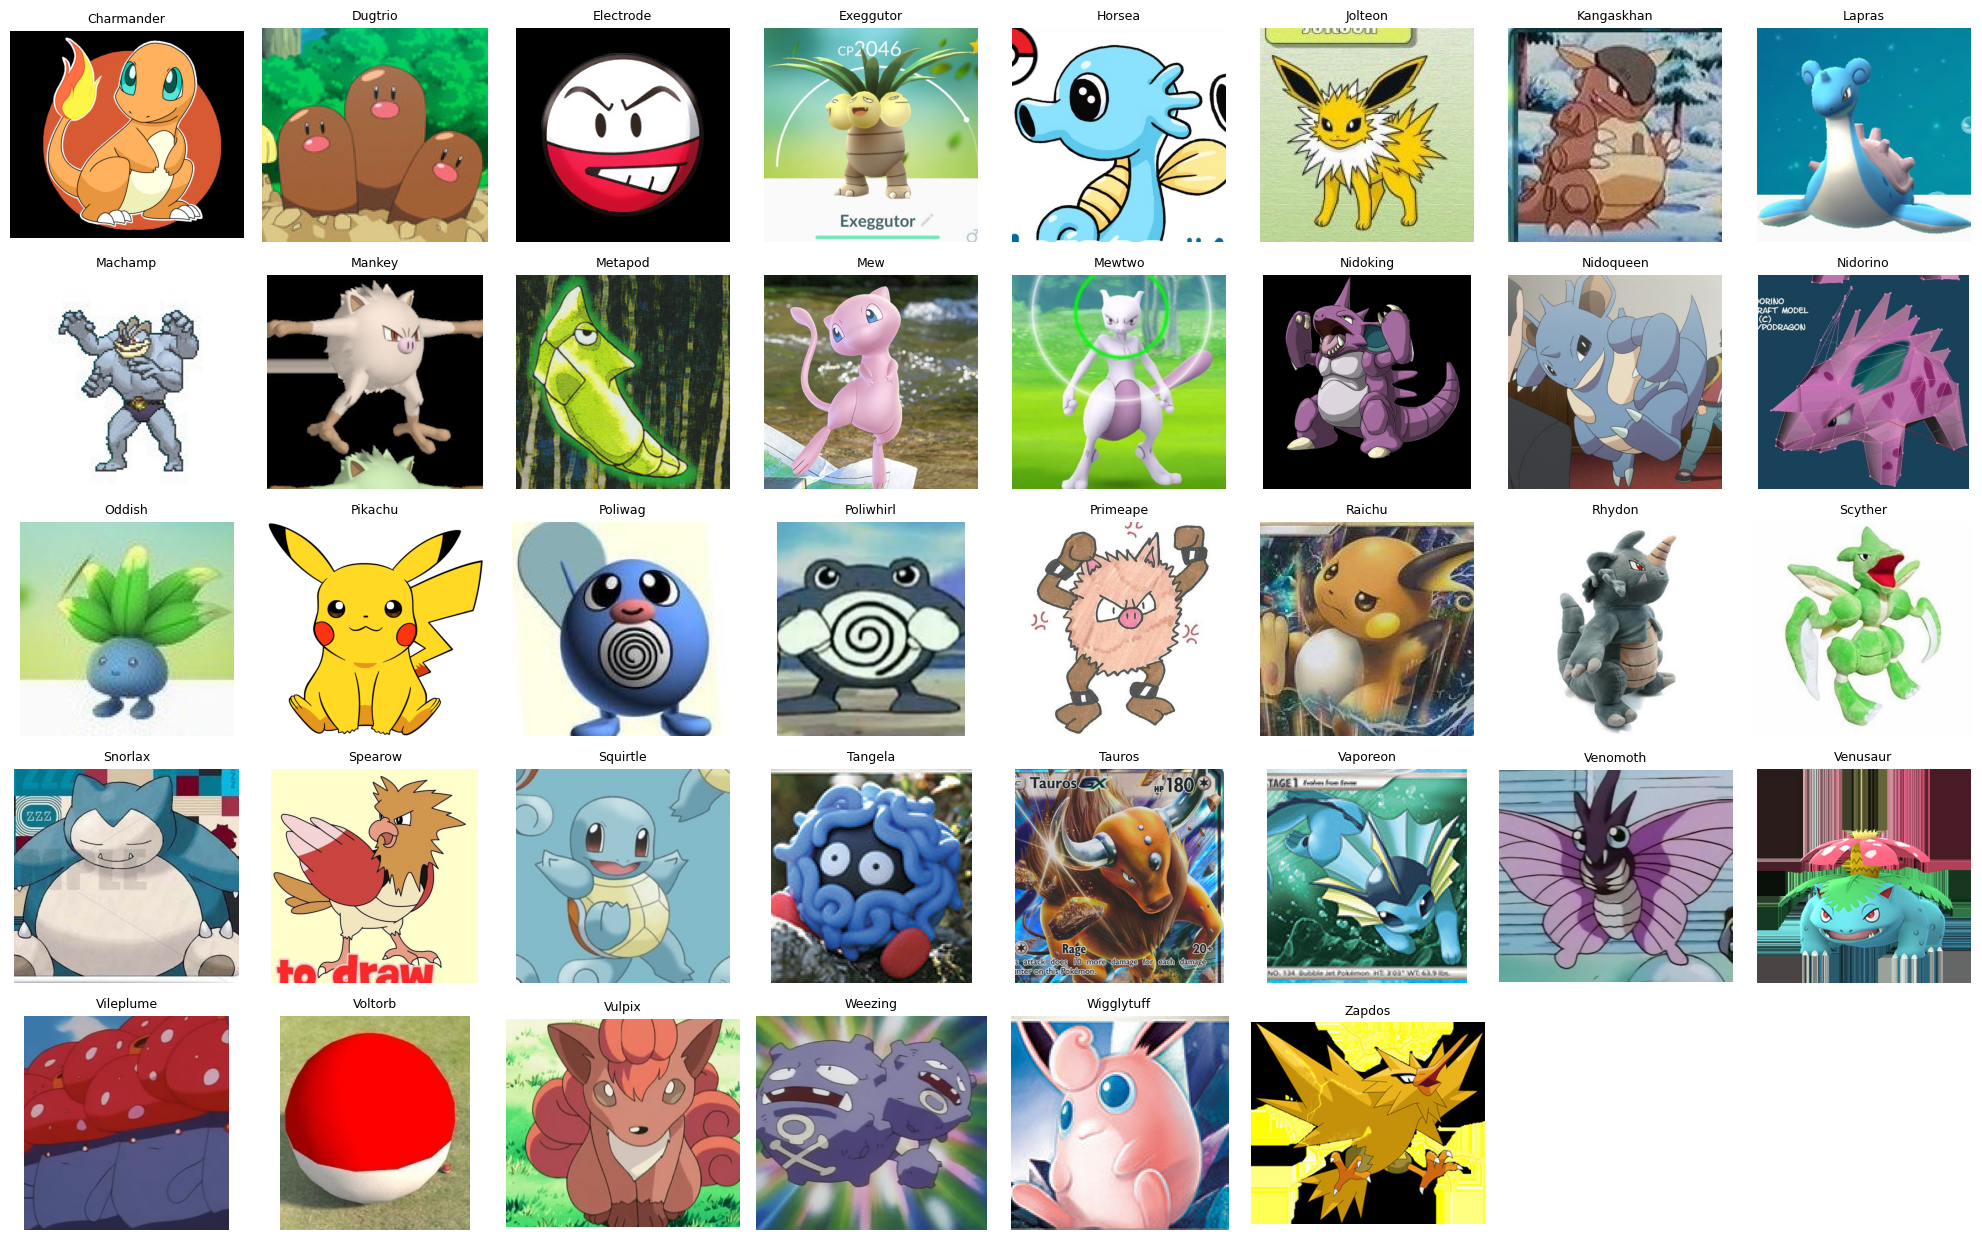

In [9]:


# Calculate grid size dynamically
folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
folders = sorted(folders)  # Sort alphabetically

n_classes = len(folders)
n_cols = 8
n_rows = math.ceil(n_classes / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
axs = axs.flatten()

# Plot one image per class
for ax, folder in zip(axs, folders):
    img_path = os.path.join(dataset_path, folder, os.listdir(os.path.join(dataset_path, folder))[0])
    try:
        img = Image.open(img_path)
        ax.imshow(img)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error\n{e}", ha='center', va='center', fontsize=8)
    ax.set_title(folder, fontsize=9)
    ax.axis('off')

# Hide any extra subplots if there are any
for ax in axs[len(folders):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


/var/folders/5h/38lqs7dd2rn8fzv14qzz45dh0000gn/T/ipykernel_77463/1016965381.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pokémon', y='Brightness', data=data, palette="coolwarm")


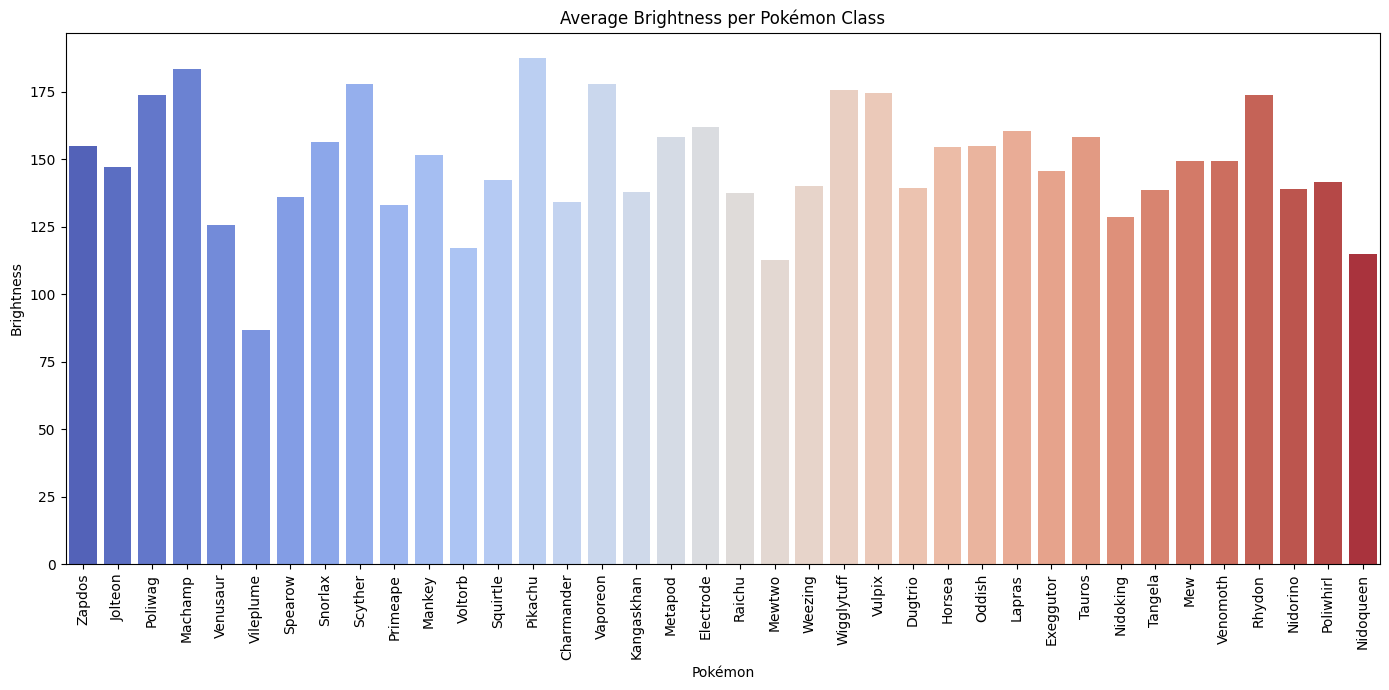

/var/folders/5h/38lqs7dd2rn8fzv14qzz45dh0000gn/T/ipykernel_77463/1016965381.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pokémon', y='Contrast', data=data, palette="coolwarm")


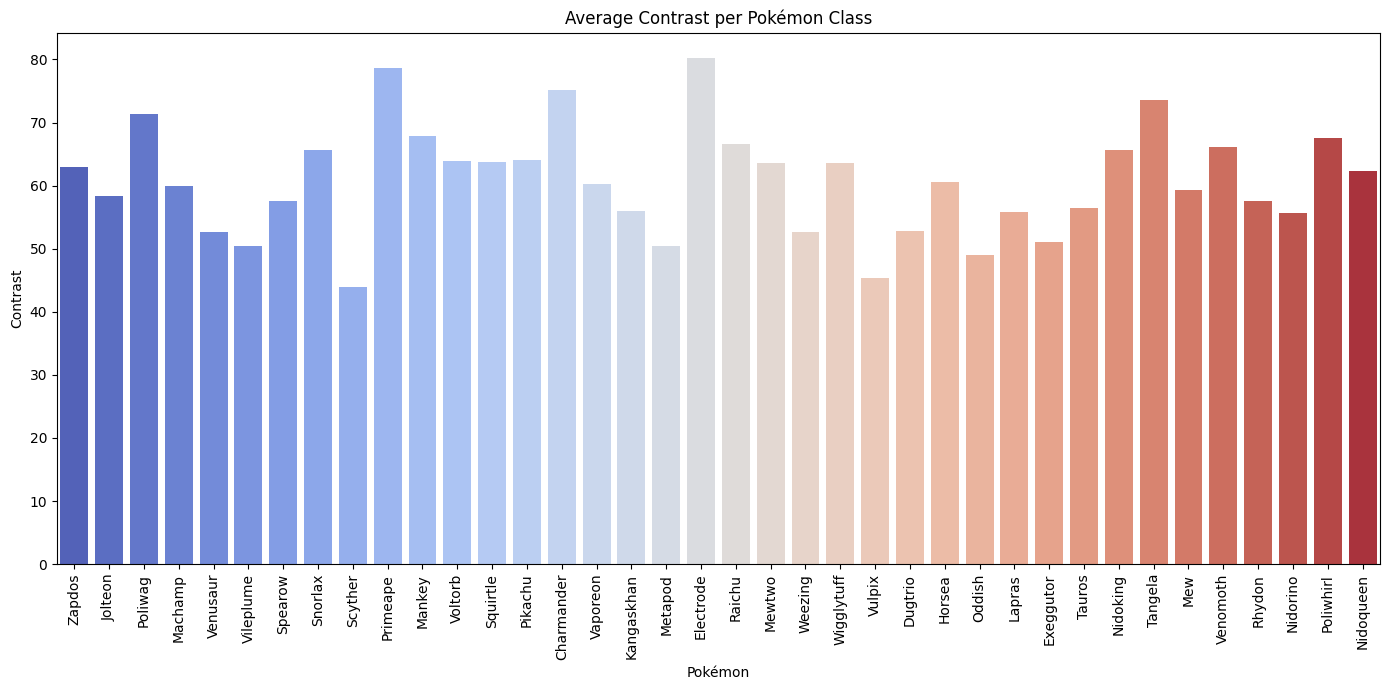

In [10]:


brightness = {}
contrast = {}

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        folder_brightness = []
        folder_contrast = []
        # Use just one image per folder or average 
        for img_name in os.listdir(folder_path)[:5]:
            try:
                img = Image.open(os.path.join(folder_path, img_name)).convert('L')  # grayscale
                img_np = np.array(img)
                folder_brightness.append(np.mean(img_np))
                folder_contrast.append(np.std(img_np))
            except Exception as e:
                print(f"Skipping {img_name} in {folder}: {e}")
        brightness[folder] = np.mean(folder_brightness)
        contrast[folder] = np.mean(folder_contrast)

# Plot brightness
data = pd.DataFrame({'Pokémon': list(brightness.keys()), 'Brightness': list(brightness.values())})
plt.figure(figsize=(14, 7))
sns.barplot(x='Pokémon', y='Brightness', data=data, palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Average Brightness per Pokémon Class')
plt.tight_layout()
plt.show()

# Plot contrast
data = pd.DataFrame({'Pokémon': list(contrast.keys()), 'Contrast': list(contrast.values())})
plt.figure(figsize=(14, 7))
sns.barplot(x='Pokémon', y='Contrast', data=data, palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Average Contrast per Pokémon Class')
plt.tight_layout()
plt.show()


2025-05-04 00:10:12.067915: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-04 00:10:12.067952: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-04 00:10:12.067963: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-04 00:10:12.067986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-04 00:10:12.068004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-04 00:10:14.893579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

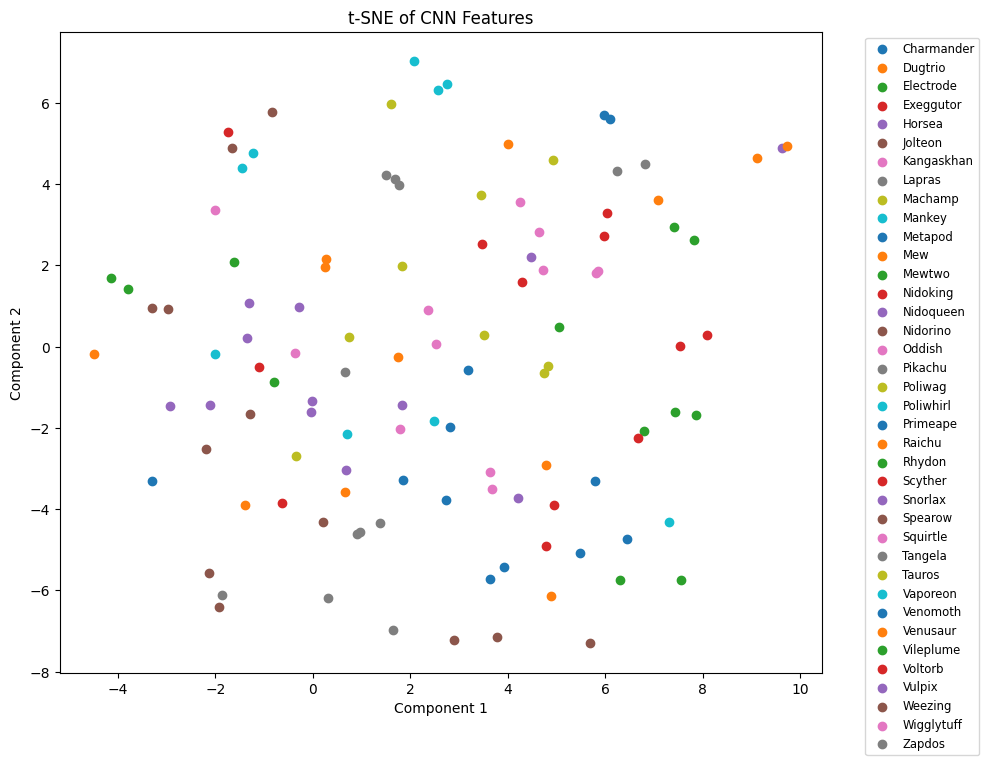

In [11]:
# Initialize pre-trained model, excluding top layers
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

features = []
labels = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        img_files = os.listdir(folder_path)
        # Process a small sample per class
        for img_name in img_files[:3]:
            img_path = os.path.join(folder_path, img_name)
            try:
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                feat = model.predict(x)
                features.append(feat.flatten())
                labels.append(folder)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

features = np.array(features)
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title('t-SNE of CNN Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()


In [ ]:
print("EfficientNetB0:", model_B0.count_params(), "parameters")
print("ResNet50:", model_ResNet50.count_params(), "parameters")
print("MobileNetV2:", model_V2.count_params(), "parameters")

import time
start = time.time()
model_B0.predict(test_generator_B0)
print("EfficientNetB0 time:", time.time() - start)

import time
start = time.time()
model_ResNet50.predict(test_generator_B0)
print("ResNet50 time:", time.time() - start)

import time
start = time.time()
model_V2.predict(test_generator_B0)
print("MobileNetV2 time:", time.time() - start)
